# Parte 2: Algoritmo de Canny


In [1]:
# Librerías principales
import numpy as np
import cv2 as cv
import matplotlib
from matplotlib import pyplot as plt

# Tipo de visualización
%matplotlib inline

# Versiones de librerías
print("".join(f"{x[0]}: {x[1]}\n" for x in [
    ("Numpy",np.__version__),
    ("openCV",cv.__version__),
    ("Matplotlib",matplotlib.__version__),
]))

Numpy: 1.22.3
openCV: 4.5.5
Matplotlib: 3.5.1



## Imágenes
Se levantan las imágenes que se empleará como prueba.


In [2]:
# Definición de la ruta para levantar las imagenes
PATH = r'D:\Profesion\Disciplinas\vision_computadora_I\practicas\tp_2\data'

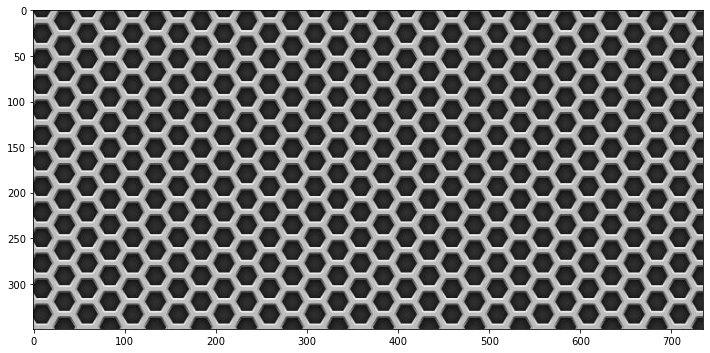

Dimensiones de las imágenes (350, 735)


In [3]:
# Se levanta la imagen en escala de grises
metalgrid = cv.imread(os.path.join(PATH, 'metalgrid.jpg'), cv.IMREAD_GRAYSCALE)

# Verificación si ha levantado la imagen 
fig = plt.figure(figsize=(12, 10))
plt.imshow(metalgrid, cmap='gray')
plt.show()

# Verificación de dimensiones y canales
print(f'Dimensiones de las imágenes {metalgrid.shape}')


## Gradientes y ángulos
En primer lugar, se determinan los valores de gradientes y ángulos. Luego se buscarán las referencias de valores principales para ajustar el algoritmo de armado de bordes en función de dichos datos. 

In [4]:
# Suavizado Gaussiano
blur = cv.GaussianBlur(metalgrid,(5,5),0)

# Sobelx para remarcar bordes. Se hace en 'float32' y luego convertimos de nuevo a 8-bit para evitar overflow
sobelx_32 = cv.Sobel(blur,cv.CV_32F,1,0,ksize=3)
absx_32 = np.absolute(sobelx_32)
sobelx_8u1 = absx_32/absx_32.max()*255
sobelx_8u = np.uint8(sobelx_8u1)

# Idem para Sobely
sobely_32 = cv.Sobel(blur,cv.CV_32F,0,1,ksize=3)
absy_32 = np.absolute(sobely_32)
sobely_8u1 = absy_32/absy_32.max()*255
sobely_8u = np.uint8(sobely_8u1)

# Magnitud de gradiente y pasaje a 8-bit (Opcional)
mag = np.hypot(sobelx_8u, sobely_8u)
mag = mag/mag.max()*255
mag = np.uint8(mag)

# Dirección de gradientes y pasaje a grados
theta = np.arctan2(sobely_32, sobelx_32)
angle = np.rad2deg(theta)


In [5]:
# Valores umbrales de los gradientes y sus ángulos
mag_max = np.max(mag)
mag_min = np.min(mag)
angle_max = np.max(angle)
angle_min = np.min(angle)

print("Valor máximo de gradiente:", mag_max)
print("Valor mínimo de gradiente:", mag_min)
print("Valor máximo de ángulo:", angle_max)
print("Valor mínimo de ángulo:", angle_min)

Valor máximo de gradiente: 255
Valor mínimo de gradiente: 0
Valor máximo de ángulo: 180.0
Valor mínimo de ángulo: -179.63034


Ahora se presentan los histogramas de gradientes y ángulos. Los datos que arrojen, ayudarán a ajustar el algoritmo para establecer los bordes correspondientes a gradientes representativos.

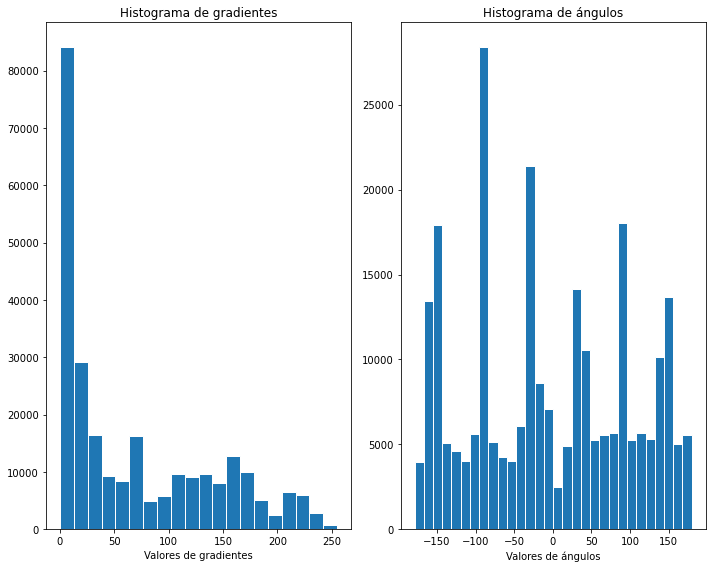

In [6]:
# Histogramas
fig = plt.figure(figsize=(10,8))

ax1=plt.subplot(121)
ax1.hist(mag.ravel(), bins=20, range=[0, 255], rwidth=1, edgecolor='white')
ax1.set_xlabel('Valores de gradientes')
ax1.set_title('Histograma de gradientes')

ax2=plt.subplot(122)
ax2.hist(angle.ravel(), bins=30, range=[-179, 180], rwidth=1, edgecolor='white')
ax2.set_xlabel('Valores de ángulos')
ax2.set_title('Histograma de ángulos')

fig.tight_layout()
plt.show()

Los valores arrojados para el gradiente no resultan obvios. El rango de valores es realmente amplio. Los valores extremadamente bajos son mayoritarios. En ese sentido, por lo que arroja la gráfica, se pueden ver tres agrupamientos. Para el caso a resolver, se tomará el primero de ellos, considerando los valores umbrales 70 y 10.

Ahora vamos al tema ángulos. La imagen muestra un reticulado hexagonal. Por lo que se espera que la mayoría de los gradientes actuasen "como si" fueran la normal a cada lado de la figura mencionada. Esto es, que sus ángulos se encuentren en torno a:
- 30°.
- 90°.
- 150°.
- -30°.
- -90°.
- -150°

El histograma de ángulos presenta máximo en torno a los valores mencionados. 

## Imagen de bordes
Se construye la imagen de bordes. El mapeo de píxeles dado un rango de ángulos de cada uno de ellos respecto a sus vecinos, estará dado por los ángulos que fraccionan un hexágono en seis partes. La imagen resultante es en blanco y negro. 

In [7]:
# Mapeo de píxeles
M, N = mag.shape
Non_max = np.zeros((M,N), dtype= np.uint8)

for i in range(1,M-1):
    for j in range(1,N-1):
        # Horizontal
        if (0 == angle[i,j]) or (angle[i,j] == 180):
            b = mag[i, j+1]
            c = mag[i, j-1]
        # Diagonal 60
        if (0 < angle[i,j] <= 60) or (-180 < angle[i,j] < -120):
            b = mag[i+1, j+1]
            c = mag[i-1, j-1]
        # Vertical 90
        elif (60 < angle[i,j] < 120) or (-120 < angle[i,j] < -60):
            b = mag[i+1, j]
            c = mag[i-1, j]
        # Diagonal 120
        elif (120 <= angle[i,j] < 180) or (-60 <= angle[i,j] < 0):
            b = mag[i+1, j-1]
            c = mag[i-1, j+1]           
            
        # Supresión de no-máximos
        if (mag[i,j] >= b) and (mag[i,j] >= c):
            Non_max[i,j] = mag[i,j]
        else:
            Non_max[i,j] = 0


# Umbralizado por histéresis
#===========================
UmbralAlto = 70
UmbralBajo = 10

M, N = Non_max.shape
out = np.zeros((M,N), dtype= np.uint8)

# Si la intensidad de un borde es mayor a 'UmbralAlto' es seguro un umbral, debajo de 'UmbralBajo' seguro no es
strong_i, strong_j = np.where(Non_max >= UmbralAlto)
zeros_i, zeros_j = np.where(Non_max < UmbralBajo)

# Bordes débiles
weak_i, weak_j = np.where((Non_max <= UmbralAlto) & (Non_max >= UmbralBajo))

# Setear el mismo valor a todos los tipos de píxel
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 75

# Armado de la imagen de bordes
#=========================
M, N = out.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out[i,j] == 75):
            if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                out[i, j] = 255
            else:
                out[i, j] = 0

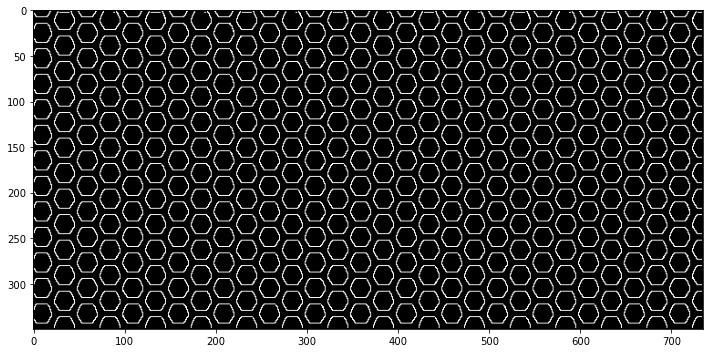

In [8]:
# Visualización de imagen de bordes
fig = plt.figure(figsize=(12, 10))
plt.imshow(out, cmap='gray')
plt.show()